# Finding the MRI brain tumor detection dataset

In [1]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 248MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg 

Let's find the dataset in this link: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Import packages

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

## Reading the Images

In [12]:
tumor = []
healthy = []
for f in glob.iglob("/content/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("/content/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [14]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [15]:
healthy.shape

(85, 128, 128, 3)

In [16]:
tumor.shape

(86, 128, 128, 3)

In [17]:
np.random.choice(10, 5, replace=False)

array([8, 9, 1, 5, 7])

# Visualizing Brain MRI Images

In [18]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])





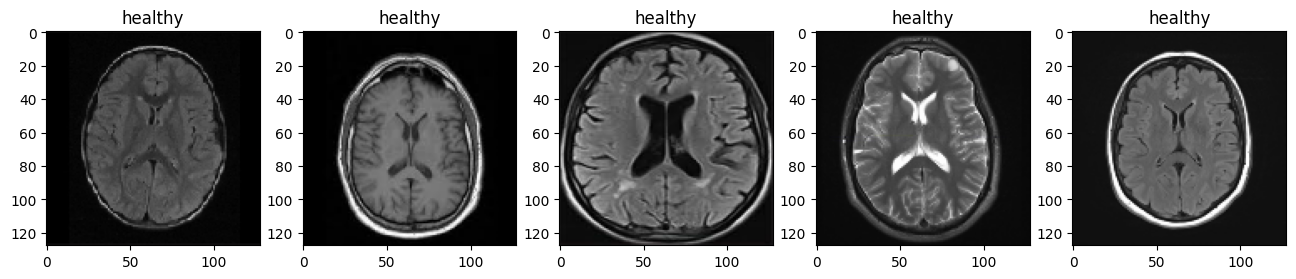

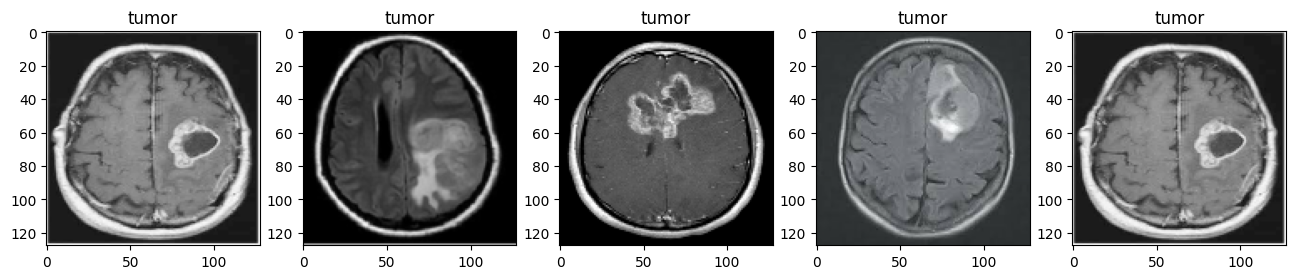

In [19]:
plot_random(healthy, tumor, num=5)

 # Create Torch Dataset Class

## What is Pytorch's Abstract Dataset Class

In [20]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

## Creating MRI cutom dataset class

In [21]:
class MRI(Dataset):
    def __init__(self):

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("/content/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("/content/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):

        sample = {'image': self.images[index], 'label':self.labels[index]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

In [22]:
mri_dataset = MRI()
mri_dataset.normalize()

# Creating a dataloader

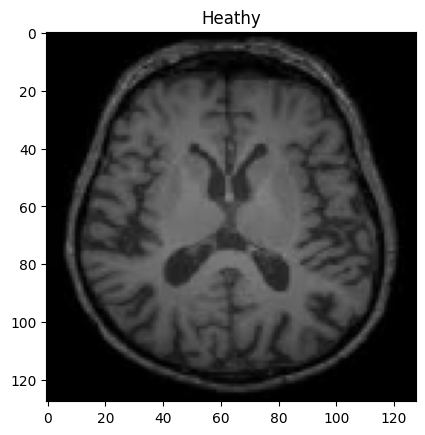

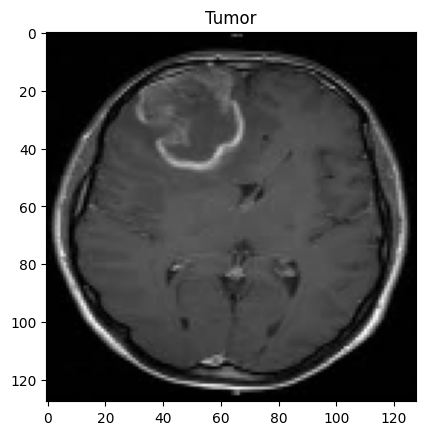

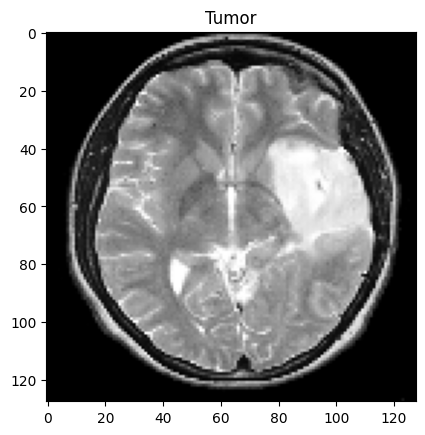

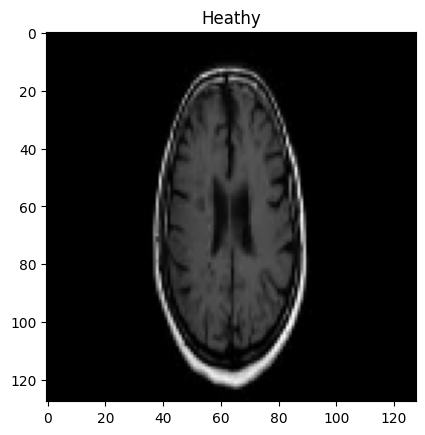

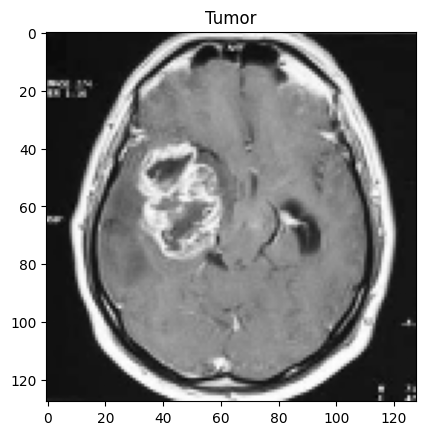

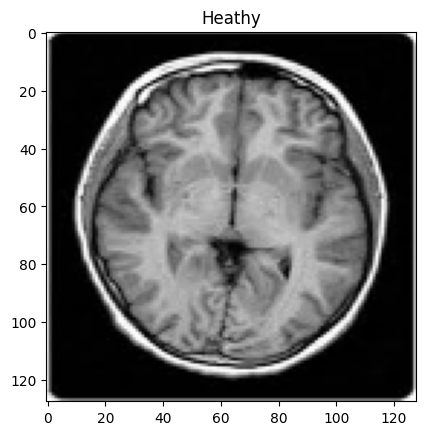

In [54]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create a model

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x


# Some Basics of Training and Evaluation in Pytorch

## model.eval()

- Used particularly for inference **NOTHING to DO with gradients!!!**
- changes the forward() behaviour of the module it is called up on eg, it disables dropout and has batch norm use the entire population statistics. This is necessary for inference

## model.train()

- Brings drop out and batch norm to action (i.e., train mode).
- Gradients are computed

## numpy array vs tensor

The difference between a NumPy array and a tensor is that the tensors are backed by the accelerator memory like GPU and they are immutable, unlike NumPy arrays. You can never update a tensor but create a new one. If you are into machine learning or going to be into it, A Tensor is a suitable choice if you are going to use GPU. A tensor can reside in accelerator’s memory.

- The numpy arrays are the core functionality of the numpy package designed to support faster mathematical operations. Unlike python’s inbuilt list data structure, they can only hold elements of a single data type. Library like pandas which is used for data preprocessing is built around the numpy array. **Pytorch tensors are similar to numpy arrays, but can also be operated on CUDA-capable Nvidia GPU.**
- Numpy arrays are mainly used in typical machine learning algorithms (such as k-means or Decision Tree in scikit-learn) whereas pytorch tensors are mainly used in deep learning which requires heavy matrix computation.
- Unlike numpy arrays, while creating pytorch tensor, it also accepts two other arguments called the device_type (whether the computation happens on CPU or GPU) and the requires_grad (which is used to compute the derivatives).

## torch.tensor vs. torch.cuda.tensor

he key difference is just that torch.Tensor occupies CPU memory while torch.cuda.Tensor occupies GPU memory. Of course operations on a CPU Tensor are computed with CPU while operations for the GPU / CUDA Tensor are computed on GPU.

In [55]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.3029, 0.0144, 0.1883, 0.8826, 0.5005, 0.3256, 0.7182, 0.9565, 0.1017,
        0.6565], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.3029, 0.0144, 0.1883, 0.8826, 0.5005, 0.3256, 0.7182, 0.9565, 0.1017,
        0.6565], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([9.1771e-02, 2.0802e-04, 3.5455e-02, 7.7901e-01, 2.5055e-01, 1.0600e-01,
        5.1576e-01, 9.1481e-01, 1.0339e-02, 4.3106e-01], device='cuda:0')


As the underlying hardware interface is completely different, CPU Tensors are just compatible with CPU Tensor and vice versa GPU Tensors are just compatible to GPU Tensors.

### In which scenario is torch.cuda.Tensor() necessary?

When you want to use GPU acceleration (which is much faster in most cases) for your program, you need to use torch.cuda.Tensor, but you have to make sure that ALL tensors you are using are CUDA Tensors, mixing is not possible here.

### tensor.cpu().detach().numpy(): Convert Pytorch tensor to Numpy array

As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command.
.cpu() returns a copy of this object in CPU memory.

# Evaluate a New-Born Neural Network!

In [26]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [27]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [28]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())



In [29]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [30]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [31]:
accuracy_score(y_true, threshold(outputs))

0.5029239766081871

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

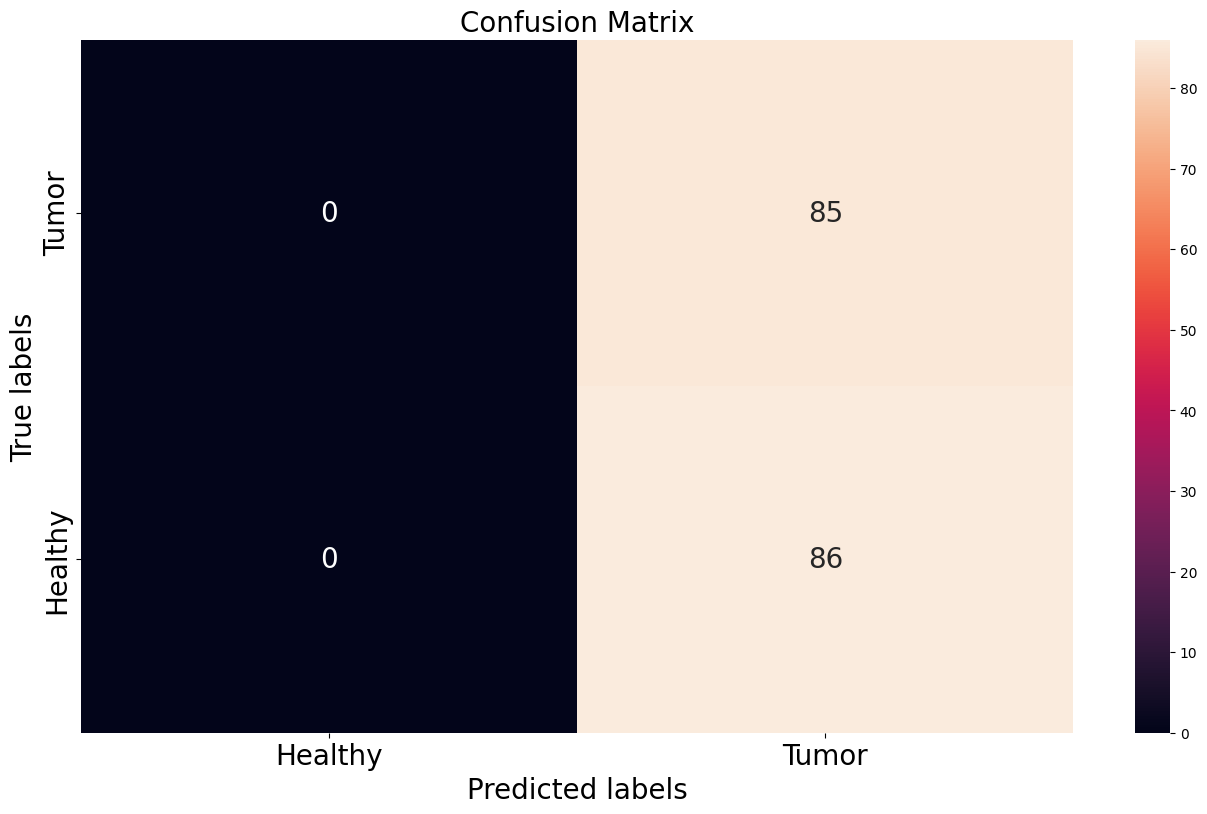

In [32]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

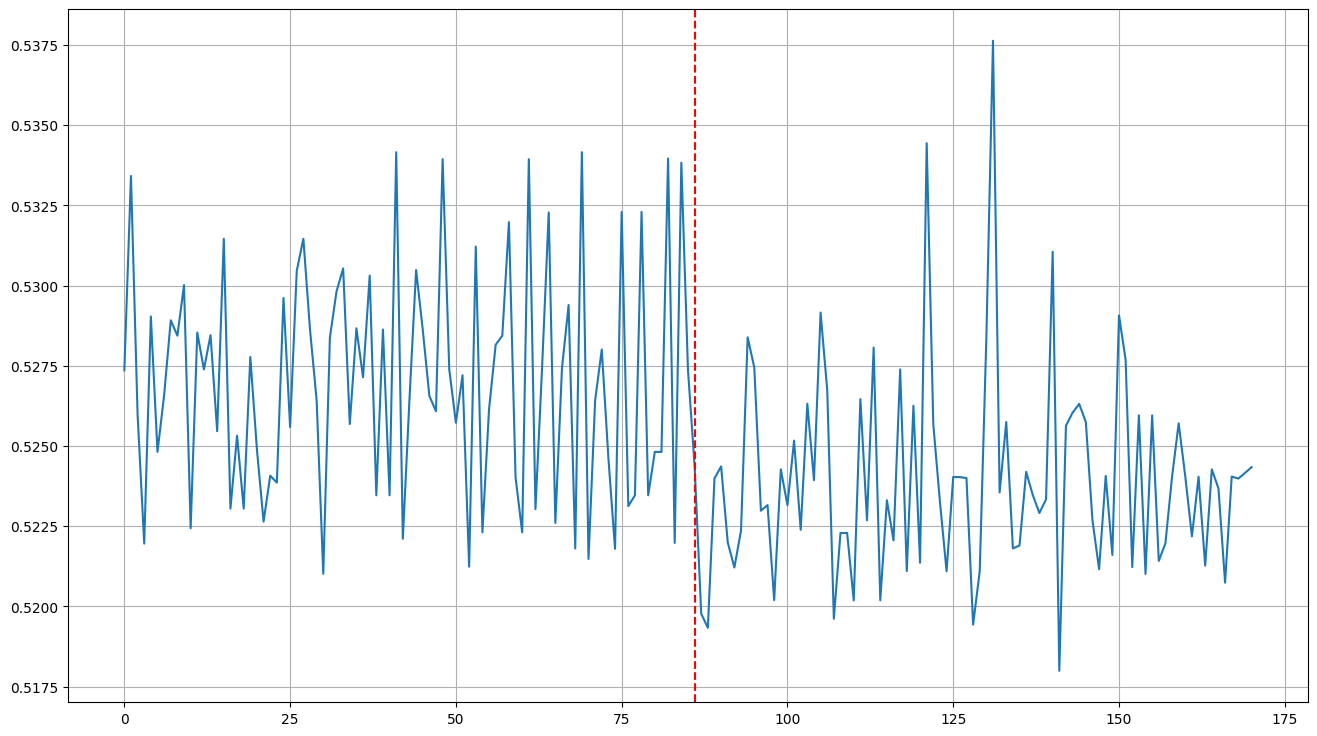

In [33]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Train the dumb model

In [34]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [35]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.665928
Train Epoch: 20	Loss: 0.591428
Train Epoch: 30	Loss: 0.566981
Train Epoch: 40	Loss: 0.535915
Train Epoch: 50	Loss: 0.532729
Train Epoch: 60	Loss: 0.506427
Train Epoch: 70	Loss: 0.469627
Train Epoch: 80	Loss: 0.428715
Train Epoch: 90	Loss: 0.427115
Train Epoch: 100	Loss: 0.355203
Train Epoch: 110	Loss: 0.345586
Train Epoch: 120	Loss: 0.321733
Train Epoch: 130	Loss: 0.284563
Train Epoch: 140	Loss: 0.282253
Train Epoch: 150	Loss: 0.252708
Train Epoch: 160	Loss: 0.228364
Train Epoch: 170	Loss: 0.204866
Train Epoch: 180	Loss: 0.190673
Train Epoch: 190	Loss: 0.166396
Train Epoch: 200	Loss: 0.139627
Train Epoch: 210	Loss: 0.127379
Train Epoch: 220	Loss: 0.103089
Train Epoch: 230	Loss: 0.088282
Train Epoch: 240	Loss: 0.076829
Train Epoch: 250	Loss: 0.066430
Train Epoch: 260	Loss: 0.054037
Train Epoch: 270	Loss: 0.041839
Train Epoch: 280	Loss: 0.033285
Train Epoch: 290	Loss: 0.026813
Train Epoch: 300	Loss: 0.028815
Train Epoch: 310	Loss: 0.023122
Train Epoch: 320	

# Evaluate a smart model

In [97]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )


[[9.9999571e-01]
 [9.9999869e-01]
 [9.9998331e-01]
 [9.9300730e-01]
 [9.8364568e-01]
 [9.9999845e-01]
 [9.9920291e-01]
 [9.9432266e-01]
 [9.9968386e-01]
 [9.9714226e-01]
 [9.9990201e-01]
 [9.9998152e-01]
 [9.9999595e-01]
 [9.9997663e-01]
 [9.9975282e-01]
 [9.9763513e-01]
 [9.9111032e-01]
 [9.9390703e-01]
 [9.9104100e-01]
 [9.9924421e-01]
 [9.8247486e-01]
 [9.7358650e-01]
 [9.8176128e-01]
 [9.8515946e-01]
 [9.9999821e-01]
 [9.8550373e-01]
 [9.9895501e-01]
 [9.9763513e-01]
 [9.9955362e-01]
 [9.9998808e-01]
 [9.9994445e-01]
 [9.9999940e-01]
 [9.9918288e-01]
 [9.9839276e-01]
 [9.9524432e-01]
 [9.9998426e-01]
 [9.9983490e-01]
 [9.9568295e-01]
 [9.9999833e-01]
 [9.9955362e-01]
 [9.9999833e-01]
 [9.9782264e-01]
 [9.9999845e-01]
 [9.9865806e-01]
 [9.9989831e-01]
 [9.9955362e-01]
 [9.9955612e-01]
 [9.8757488e-01]
 [9.9996316e-01]
 [9.9999595e-01]
 [9.9999750e-01]
 [9.9707246e-01]
 [9.9349993e-01]
 [9.9364012e-01]
 [9.9141109e-01]
 [9.8148751e-01]
 [9.9999297e-01]
 [9.9968386e-01]
 [9.7380042e-0

In [39]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

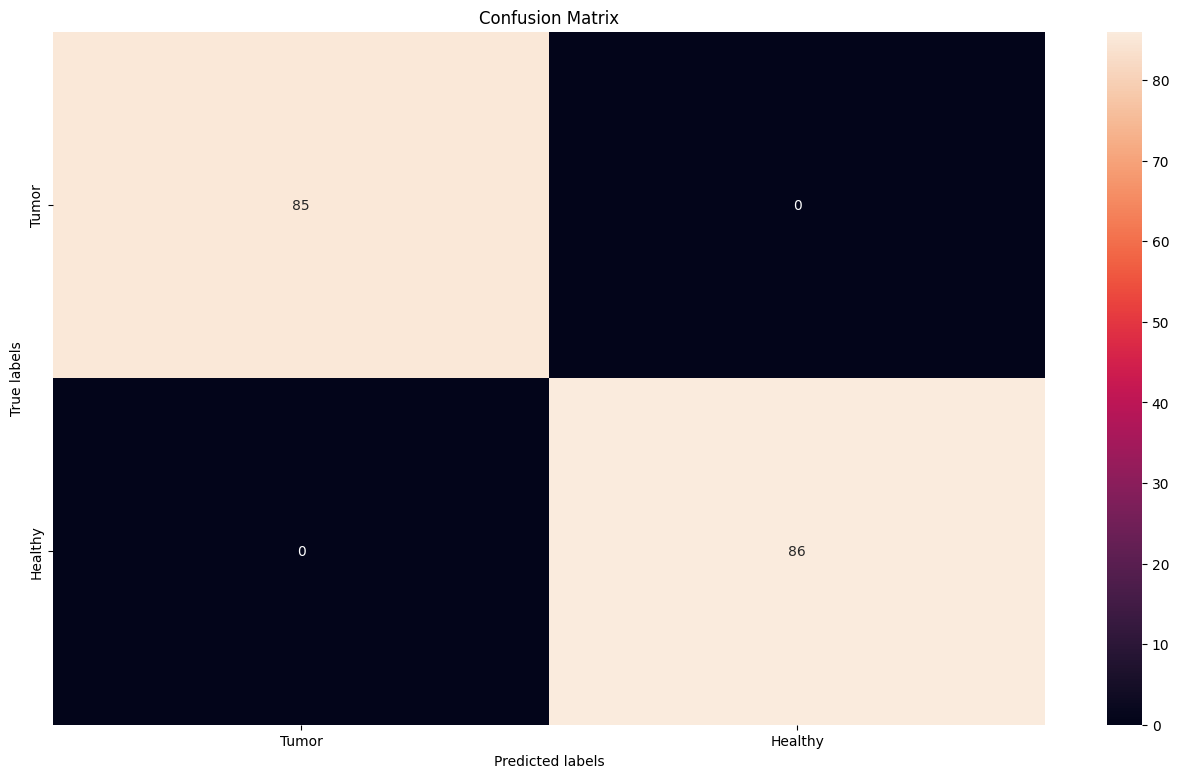

In [40]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

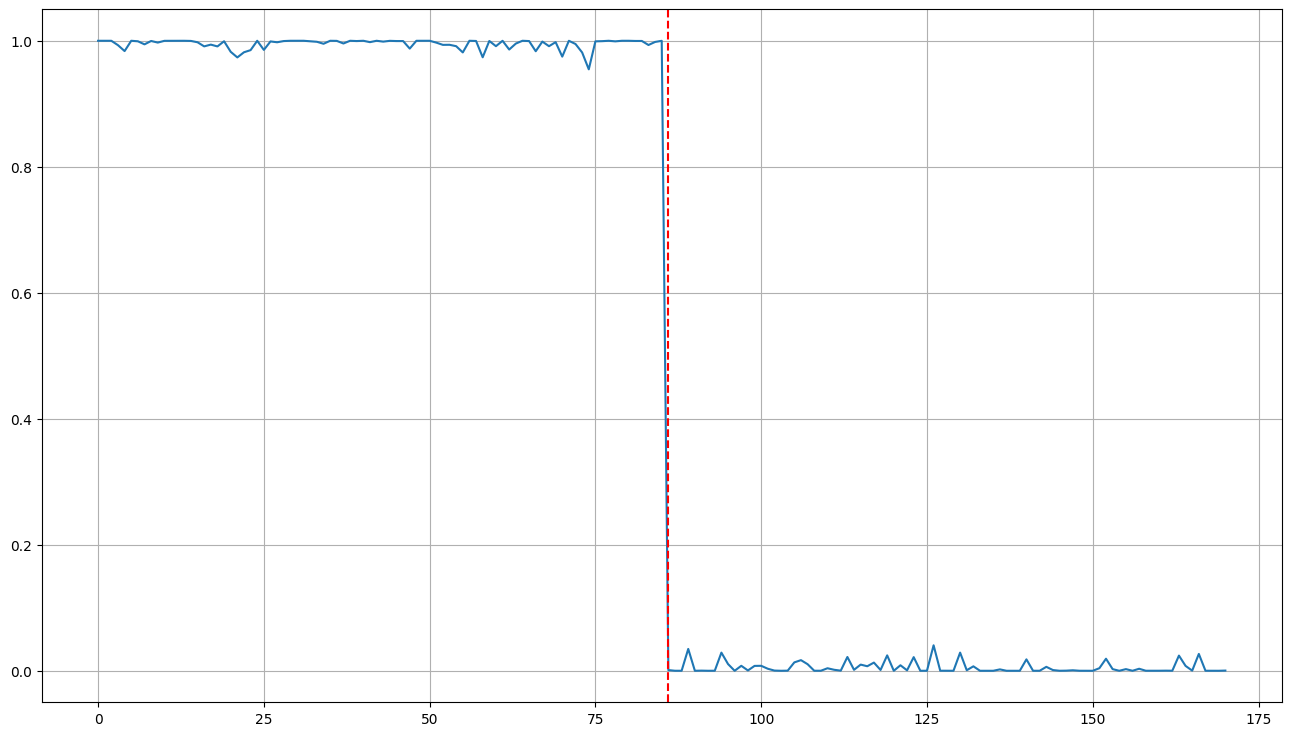

In [41]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [93]:
# import cv2
# import torch
# import torchvision.transforms as transforms

# # Load and preprocess the image using OpenCV
# img = cv2.imread("/content/yes/Y116.JPG")
# img = cv2.resize(img, (128, 128))
# b, g, r = cv2.split(img)
# img = cv2.merge([r, g, b])
# img = img / 255.0

# # Define preprocessing transformations
# preprocess = transforms.Compose([
#     transforms.ToTensor(),  # Convert numpy array to PyTorch tensor
#     # You may need additional preprocessing steps such as normalization
# ])

# # Preprocess the image
# input_tensor = preprocess(img)

# # Add batch dimension
# input_batch = input_tensor.unsqueeze(0)

# # Move the input batch to the appropriate device
# input_batch = input_batch.to(device)
# input_batch = input_batch.float()

# # Pass the input through the model
# with torch.no_grad():
#     output = model(input_batch)

# _, predicted = torch.max(output, 1)
# predicted_class = predicted.item()
# print("Predicted class:", predicted_class)


Predicted class: 0
